In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from skimage import io
import PIL,os,mimetypes, glob
from skimage.io import imread
from natsort import natsorted

In [3]:
#export
Path.ls = lambda x: list(x.iterdir())
PIL.Image.MAX_IMAGE_PIXELS = None

In [4]:
#export
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [5]:
#export
class ImageSlicer():
    
    def __init__(self, source, slice_s, overlap):
        self.source = source
        self.slice_s = slice_s
        self.overlap = overlap
        
    def _get_files(p, fs, extensions=image_extensions):
        p = Path(p)
        res = [p/f for f in fs if not f.startswith('.')
               and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
        return res
        
    def _read_images(self):
        Images = []
        image_names = sorted(os.listdir(self.source))
        for im in image_names:
            image = plt.imread(os.path.join(dir_path,im))
            Images.append(image)
        return Images
                    
    

    def _convolution(self, Image, strides, slice_s):
        start_x = 0
        start_y = 0
        n_rows = Image.shape[0]//strides[0] + 1
        minus = divmod(slice_s,strides[0])[0]
        n_columns = Image.shape[1]//strides[1] + 1
    
        small_images = []
        for i in range(n_rows-1):
            for j in range(n_columns-minus):
                new_start_x = start_x+i*strides[0]
                new_start_y= start_y+j*strides[1]
                small_images.append(Image[new_start_x:new_start_x+self.slice_s,new_start_y:new_start_y+self.slice_s,:])
        return small_images
                    
    def _transform(self, cb):
        image = imread(self.source)
        Images = [image]

        im_size = Images[0].shape
        num_images = len(Images)
        transformed_images = dict()
        Images = np.array(Images)

        stride_x = []
        stride_y = []

        if self.overlap == None:
            stride_x = self.slice_s
            stride_y = self.slice_s
        elif self.overlap == 0 or self.overlap == 1:
            stride_x = self.slice_s
            stride_y = self.slice_s
        elif self.overlap > 1:
            stride_x = self.slice_s/self.overlap*(self.overlap-1)
            stride_x = int(stride_x)
            stride_y = self.slice_s/self.overlap*(self.overlap-1)
            stride_y = int(stride_x)

        strides = [stride_x, stride_y]
    
        n_rows = Images[0].shape[0]//strides[0] + 1
        n_columns = Images[0].shape[1]//strides[1] + 1
        if cb: cb.before_cal_2(rows_n= n_rows,columns_n = n_columns )
            
                    
        for i, Image in enumerate(Images):
            transformed_images[str(i)] = self._convolution(Image, strides, self.slice_s)

        return transformed_images
        
    def quantile_from_slice_range(slice_range):
        if len(list(slice_range)) == 2:
            _slice_size_0 = int(slice_range[0])
            _slice_size_1 = int(np.percentile(slice_range, 25, axis=0))
            _slice_size_2 = int(np.percentile(slice_range, 50, axis=0))
            _slice_size_3 = int(np.percentile(slice_range, 75, axis=0))
            _slice_size_4 = int(slice_range[1])

            slice_l = [_slice_size_0,_slice_size_1 , _slice_size_2 ,  _slice_size_3 , _slice_size_4 ]
            return slice_l
        else:
                    return slice_range
                    

    def show_slices(slice_l, inp_d , pos= None):
        
        if pos == None:
            pos = 0
        
        inp_d = Path(inp_d)
                    
        sl = [o.name for o in os.scandir(inp_d)]
        sl = ImageSlicer._get_files(inp_d, sl)
                    
        im = Image.open(sl[pos])
        
        cropped_l = []
        for i in slice_l:
            left, top, right, bottom = 0, 0, i, i
            c  = im.crop( ( left, top, right, bottom ) )
            cropped_l.append(c) 
            
        Tot = number_of_subplots=len(slice_l)
        Tot = Tot +1
        Cols = 2
        Rows = Tot // Cols 
        Rows += Tot % Cols
        Position = range(1,Tot)

        fig = plt.figure(figsize=(12,12))

        for j, k in enumerate(cropped_l):
            ax = fig.add_subplot(Rows,Cols,Position[j])
            ax.imshow(k,interpolation='lanczos' )     
            ax.set_axis_off()
            ax.set_title(f'{slice_l[j]} Pixel')
        plt.show()

    def slice_images(inp_d = None, dir_name = None, slice_l = None, resize= None, overlap = None, out_path= None, cb=None, half_empty = True):
                    
        inp_d = Path(inp_d)
        if out_path==None:
                    out_path = inp_d
        out_path = Path(inp_d)
                    
        im_l = [o.name for o in os.scandir(inp_d)]
        im_l = ImageSlicer._get_files(inp_d, im_l)

        cb = PrintStatusCallback(overlap,resize)

        for i in slice_l:
            last_slice = slice_l[-1]

            if cb: cb.before_calc(i)
            for p, im in enumerate(im_l):
                li = len(im_l)
                if cb: cb.status_calc(p , li)
                slicer = ImageSlicer(im, slice_s = i ,overlap=overlap) 
                transformed_image = slicer._transform(cb)
                ImageSlicer._save_images(transformed=transformed_image,resize=resize , out_path=out_path , dir_name=dir_name, _slice_size=i , overlap = overlap, im = im, half_empty = half_empty)
            if cb: cb.after_calc(i, last_slice, out_path/dir_name) 
                    
    def _save_images(transformed, out_path, dir_name, resize, _slice_size=int , overlap =int ,im = None, half_empty = None):
        
        if type(resize) == tuple:
            resize_t = resize
        else:
            resize_t = ()
            resize_t = (resize , resize)
                    
        (out_path/dir_name).mkdir(exist_ok=True)       
        for key, val in transformed.items():  
            shape = val[0].shape
            count = shape[0] * shape[0]
            count_h = count//2
            for k, j in enumerate(val):
                if half_empty == True:
                    m = np.all(j == np.array((0,0,0)).reshape(1, 1, 3), axis=2)
                    non_zero = np.count_nonzero(m)
                    if non_zero <= count_h:
                        img = Image.fromarray(j, 'RGB')
                        diff = _slice_size - resize_t[0]
                        diff_h = diff//2 + resize_t[0]      
                        img.resize((diff_h, diff_h),resample=Image.BICUBIC).resize(resize_t, resample= PIL.Image.NEAREST).save(out_path/dir_name/f'{im.stem}_{k}_{overlap}_{_slice_size}.png')
                else:
                    img = Image.fromarray(j, 'RGB')
                    diff = _slice_size - resize_t[0]
                    diff_h = diff//2 + resize_t[0]      
                    img.resize((diff_h, diff_h),resample=Image.BICUBIC).resize(resize_t, resample= PIL.Image.NEAREST).save(out_path/dir_name/f'{im.stem}_{k}_{overlap}_{_slice_size}.png')


    def slice_masks(inp_d = None, dir_name = None ,slice_l = None,resize= None, overlap = None, out_path=None, cb=None, palette = None):
                    
        inp_d = Path(inp_d)
        if out_path==None:
                    out_path = inp_d
        out_path = Path(inp_d)

        mask_l = [o.name for o in os.scandir(inp_d)]
        mask_l = ImageSlicer._get_files(inp_d, mask_l)

        cb = PrintStatusCallback(overlap,resize)

        for i in slice_l:
            last_slice = slice_l[-1]

            if cb: cb.before_calc(i)
            for p, im in enumerate(mask_l):
                li = len(mask_l)
                if cb: cb.status_calc(p , li)
                slicer = ImageSlicer(im, slice_s = i ,overlap=overlap) 
                transformed_image = slicer._transform(cb)
                ImageSlicer._save_masks(transformed=transformed_image,resize=resize , out_path=out_path , dir_name=dir_name, _slice_size=i , overlap = overlap, im = im)
            if cb: cb.after_calc(i, last_slice, out_path/dir_name )    
        
        if palette != None:
                    print("----")
                    print("Convert colour to grey")
                    
                    mask_grey_l = [o.name for o in os.scandir(inp_d/dir_name)]
                    mask_grey_l = ImageSlicer._get_files(inp_d/dir_name, mask_grey_l)
                    PIL.Image.MAX_IMAGE_PIXELS = 933120000
                    for mask in mask_grey_l:
                        mask_r = io.imread(mask) 
                        mask_c = ImageSlicer._color_to_grey(mask_rgb = mask_r , palette = palette, out_path =out_path/dir_name/dir_name,dir_name = dir_name , path=mask)
                    
                    print(cb.after_calc(i,last_slice ,out_path/dir_name/dir_name ))
                    
    
    def add_padding(inp_d, pad = 500):
                    inp_d = Path(inp_d)
                    sl = [o.name for o in os.scandir(inp_d)]
                    sl = ImageSlicer._get_files(inp_d, sl)
                    (inp_d/f'out_padded').mkdir(exist_ok=True)
                    
                    for image in sl:
                        with open(image, 'rb') as file:
                            img = Image.open(file)
                            width, height = img.size
                            new_width = width + pad 
                            new_height = height + pad
                            result = Image.new(img.mode, (new_width, new_height))
                            result.paste(img, (0, 0))
                            result.save(inp_d/f'out_padded/{image.stem}.png' )
                    
    def _save_masks(transformed, out_path, dir_name, resize, _slice_size=None , overlap =int,im = None): 
        if type(resize) == tuple:
            resize_t = resize
        else:
            resize_t = ()
            resize_t = (resize , resize)
                    
        (out_path/dir_name).mkdir(exist_ok=True)
        for key, val in transformed.items():
            shape = val[0].shape
            count = shape[0] * shape[0]
            count_h = count//2
            for k, j in enumerate(val):

                m = np.all(j == np.array((0,0,0)).reshape(1, 1, 3), axis=2)
                non_zero = np.count_nonzero(m)
                if non_zero <= count_h:
                    img = Image.fromarray(j, 'RGB') 
                    img.resize(resize_t,resample=Image.NEAREST).save(out_path/dir_name/f'{im.stem}_{k}_{overlap}_{_slice_size}.png')
    
    def _color_to_grey(mask_rgb, palette=None, out_path=None, dir_name=None , path=None):
        """ RGB-color encoding to grayscale labels """
        if palette == None:
            raise Exception("Please insert palette")
        else:
            (out_path).mkdir(exist_ok=True)
            invert_palette = {v: k for k, v in palette.items()}
            mask_g = np.zeros((mask_rgb.shape[0], mask_rgb.shape[1]), dtype=np.uint8)
            for c, i in invert_palette.items():
                m = np.all(mask_rgb == np.array(c).reshape(1, 1, 3), axis=2)
                mask_g[m] = i

            mask_a = Image.fromarray(mask_g, 'L') 
            mask_a.save(out_path/f'{path.stem}.png')
                    
                    
    def _convert_to_color(arr_2d, palette=None):
        """ Numeric labels to RGB-color encoding """
        arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

        for c, i in palette.items():
            m = arr_2d == c
            arr_3d[m] = i

        return arr_3d
                    
    def predict_from_fastai_model(path_fastai_model,inp_d, dir_name, palette, rows, columns):
        path_slices = str(inp_d)

        out_f = inp_d/'predicted'
        (out_f).mkdir(exist_ok=True)
        out_folder = inp_d/'predicted'/dir_name
        (out_folder).mkdir(exist_ok=True)
                    
        learn = load_learner(path_model)
        img = []
        for filename in glob.iglob(path_slices + '/*png'):
            if os.path.isfile(filename): 
                img.append(filename)
        img_s = natsorted(img)

        ims = [open_image(i) for i in img_s] 
        for i in range(len(ims)):
            img_ds = ims[i]
            mask2 = learn.predict(img_ds)[0]
            data_n = mask2.data[0].numpy()
            a = ImageSlicer._convert_to_color(data_n, palette = palette)
            img = Image.fromarray(a, 'RGB')
            img.save(f'{out_folder}/{i}.png')

        img_p = []
        for filename in glob.iglob(str(out_folder)+'/*png'):
            if os.path.isfile(filename): # filter dirs
                img_p.append(filename)
        img_ps = natsorted(img_p)
        test_im = Image.open(img_ps[0])
        size = test_im.size[0]
        out_pred = Path(out_folder/dir_name)
        (out_pred).mkdir(exist_ok=True)

        ImageSlicer._create_collage(img_ps,size=size, rows=rows , columns = columns, out = out_pred )
                    
    def _create_collage(files, size , rows , columns, out):
        target_img = Image.new("RGB", (columns * size-size  ,rows * size-size)) 
        for k, png in enumerate(files):
            row, col = divmod(k, columns-1)
            img = Image.open(png)
            target_img.paste(img, (size * col, size * row))
 
        target_img.save(str(out) + '/' + dir_name+ '.png')
                    

class PrintStatusCallback():
    def __init__(self, overlap, resize, rows=None, columns=None):
                    self.rows = rows
                    self.columns = columns
                    print(f"Overlap = {overlap}")
                    print(f"Resize to = {resize}*{resize}")
                    print("----")
    def before_calc(self, slice_s ): 
                    print(f"Process slice: {slice_s}") 
                    
    def before_cal_2(self, rows_n, columns_n): 
                    if rows_n != self.rows:
                        self.rows = rows_n
                        print(f"Rows: {self.rows}")
                        print(f"Columns: {columns_n}")
                        print("----")

    def status_calc(self, p ,li): print(f'[{p+1}|{li}]',end='\r') 
    def after_calc (self, slice_s, last_slice,out_path, **kwargs): 
        if last_slice != None:
            print(f"Finished")
        print("----")
        if slice_s == last_slice:
            print(f'Saved under: {out_path}')  
            print('Count: ' , len(list(out_path.glob('*.png'))))

## Parameter

In [31]:
slice_range = [500, 900]
slice_l = ImageSlicer.quantile_from_slice_range(slice_range);slice_l

[500, 600, 700, 800, 900]

In [25]:
resize = 448
overlap = 0
dir_name = f'va_{resize}_{overlap}_{slice_l[0]}-{slice_l[-1]}'; dir_name

'va_448_0_900-1300'

In [26]:
palette = {0 : (255, 255, 255), # Undurchlässige Oberfläche (Weiß)
           1 : (0, 0, 255),     # Gebäude (Blau)
           2 : (0, 255, 255),   # niedrige Vegetation (Cyan)
           3 : (0, 255, 0),     # Baum (grün)
           4 : (255, 255, 0),   # Auto (gelb)
           5 : (255, 0, 0),     # Unordnung (red)
           6 : (0, 0, 0)}       # Schwarz (Schwarz)

In [39]:
inp_d = Path("D:/david/Test_data/test35")

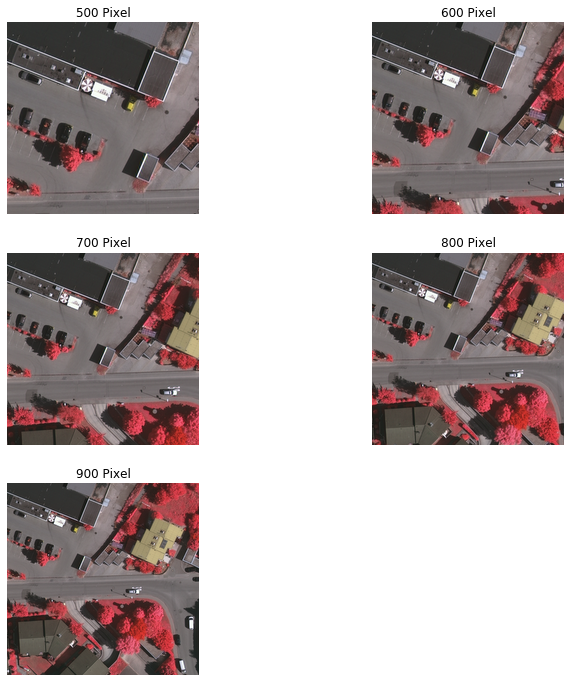

In [40]:
ImageSlicer.show_slices(slice_l, inp_d)

## Add Padding

In [56]:
inp_d = Path("D:/david/Test_data/test43")

In [57]:
pad = 400

In [58]:
ImageSlicer.add_padding(inp_d, pad = pad)

### Name train und valid muss gleich sein!!

## Train

In [59]:
inp_d = Path("D:/david/Test_data/test43/out_padded")

In [60]:
ImageSlicer.slice_images(inp_d= inp_d, dir_name = dir_name, slice_l = slice_l ,resize=resize, overlap = overlap, half_empty= False)

Overlap = 0
Resize to = 448*448
----
Process slice: 700
Rows: 4
Columns: 5
----
Finished
----
Saved under: D:\david\Test_data\test43\out_padded\va_448_0_700-700
Count:  12


## Mask train

In [107]:
inp_d2 = Path("D:/david/val_test/label/out_padded")

In [108]:
ImageSlicer.slice_masks(inp_d= inp_d2, dir_name = dir_name, slice_l = slice_l ,resize=resize, overlap = overlap , palette = palette)

Overlap = 0
Resize to = 448*448
----
Process slice: 700
Rows: 5
Columns: 4
----
Rows: 4
Columns: 5
----
Rows: 5
Columns: 4
----
Finished
----
Saved under: D:\david\val_test\label\out_padded\po_w_448_0_700-700
Count:  57
----
Convert colour to grey
Finished
----
Saved under: D:\david\val_test\label\out_padded\po_w_448_0_700-700\po_w_448_0_700-700
Count:  57
None


## Valid

In [79]:
overlap = 0

In [80]:
dir_name2 = f'po_w_{resize}_{overlap}_{slice_l[0]}-{slice_l[-1]}'; dir_name2

'po_w_224_0_900-1300'

In [81]:
slice_l2 = [1100]

In [82]:
dir_name2 = f'po_w_{resize}_{overlap}_{slice_l2[0]}-{slice_l2[-1]}'; dir_name2

'po_w_224_0_1100-1100'

In [83]:
inp_d3 = Path("D:/david/Wettbewerb/val/img/out_padded")

In [84]:
ImageSlicer.slice_images(inp_d= inp_d3, dir_name = dir_name2, slice_l = slice_l2 ,resize=resize, overlap = overlap, half_empty= True)

Overlap = 0
Resize to = 224*224
----
Process slice: 1100
Rows: 7
Columns: 7
----
Finished
----
Saved under: D:\david\Wettbewerb\val\img\out_padded\po_w_224_0_1100-1100
Count:  375


## Mask valid

In [85]:
inp_d4 = Path("D:/david/Wettbewerb/val/label/out_padded")

In [86]:
ImageSlicer.slice_masks(inp_d= inp_d4, dir_name = dir_name2, slice_l = slice_l2 ,resize=resize, overlap = overlap , palette = palette)

Overlap = 0
Resize to = 224*224
----
Process slice: 1100
Rows: 7
Columns: 7
----
Finished
----
Saved under: D:\david\Wettbewerb\val\label\out_padded\po_w_224_0_1100-1100
Count:  375
----
Convert colour to grey
Finished
----
Saved under: D:\david\Wettbewerb\val\label\out_padded\po_w_224_0_1100-1100\po_w_224_0_1100-1100
Count:  375
None


## Predict and merge

In [35]:
from fastai.vision import *
from PIL import Image

In [36]:
def acc_isprs(input, target):
    target = target.squeeze(1)
    mask = target != void_code 
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

metrics = acc_isprs
f_score1 = partial(fbeta , beta=1)

In [37]:
path_model  = Path('D:/david/va_po/im_train/va_5-9_po__9-13_448')

In [61]:
inp_d = Path("D:/david/Test_data/test43/out_padded/va_448_0_700-700")

In [62]:
rows, columns = 4,5

In [63]:
ImageSlicer.predict_from_fastai_model(path_fastai_model= path_model,inp_d= inp_d, dir_name=dir_name, palette= palette , rows= rows, columns= columns )

C:\ProgramData\Anaconda3\envs\fastai\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'fastai.vision.models.unet.DynamicUnet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\ProgramData\Anaconda3\envs\fastai\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'fastai.vision.models.unet.UnetBlock' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\ProgramData\Anaconda3\envs\fastai\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'fastai.layers.PixelShuffle_ICNR' has changed. you can retrieve the original source c

## Export

In [83]:
!python notebook2script.py Image_slicer_scale.ipynb

Converted Image_slicer_scale.ipynb to exp\nb_Image.py
